Importing the dependencies

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [2]:
import cv2



In [3]:
import tensorflow as tf 


In [4]:
real_videos_path = r"C:\Users\ASUS\OneDrive\Attachments\All Datasets\Deepfake datset\Deepfake Celeb DF real"
fake_videos_path = r"C:\Users\ASUS\OneDrive\Attachments\All Datasets\Deepfake datset\fake video copied"

In [5]:
IMG_SIZE = 128
FRAMES_PER_VIDEO = 10

Loading and Extracting the features 

In [6]:
def load_and_preprocess_videos(path, label):
    videos = []
    labels  = []
    for filename in os.listdir(path):
        if filename.endswith(".mp4") or filename.endwith(".avi"):
            try:
                videcap = cv2.VideoCapture(os.path.join(path,filename)) #THis will open the video file
               
                frames =[]
                success, Image = videcap.read()
                count = 0
                while success and count < FRAMES_PER_VIDEO:   #Extract the fixed num of frames 
                    Image = cv2.resize(Image, (IMG_SIZE, IMG_SIZE)) #resizing the frames 
                    frames.append(Image)
                    success, Image = videcap.read() #read the next frame

                    count+=1
                    
                videcap.release()

                if len(frames) == FRAMES_PER_VIDEO :
                      videos.append(np.array(frames))
                      labels.append(label)  #Add 0 for real and 1 for fake 

            except Exception as e:
                            print(f"Error processing video {filename} :{type(e).__name__} - {e}")
                            
    return np.array(videos), np.array(labels)

              


#LOad and preprocess real and fake videos 
real_videos, real_labels = load_and_preprocess_videos(real_videos_path, 0)

fake_videos, fake_labels = load_and_preprocess_videos(fake_videos_path, 1)

#combining real and fake data 
X = np.concatenate([real_videos, fake_videos])
Y= np.concatenate([real_labels, fake_labels])

#split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)
                    
            





Building the model 

In [7]:
def create_model(input_shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3)):
     
     #EfficientNet3D for spatial feature extraction 

     base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights ='imagenet',input_shape=(IMG_SIZE,IMG_SIZE, 3))

     #Load a pre-trained weights (transfer learning)
     base_model.trainable = True

     inputs = tf.keras.Input(shape=input_shape)

     X = tf.keras.layers.TimeDistributed(base_model)(inputs) # Applying EfficientNet to each frame

     X = tf.keras.layers.GlobalAveragePooling3D()(X) 
     X = tf.keras.layers.Reshape((1, -1))(X)


     #LSTM for temporal feature extraction 
     X = tf.keras.layers.LSTM(256)(X)
     X = tf.keras.layers.Dense(256, activation='relu')(X)
     X = tf.keras.layers.Dropout(0.5)(X)
     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(X)

     model = tf.keras.Model(inputs=inputs, outputs=outputs)
     return model

model = create_model()

    





Model compilation and Training 

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, Y_train,
    epochs=5, batch_size=10,  # Adjust based on your resources
    validation_data=(X_test, Y_test)
)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.8151 - loss: 0.4735 - val_accuracy: 0.8874 - val_loss: 0.2687
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 497s 6s/step - accuracy: 0.8911 - loss: 0.3352 - val_accuracy: 0.9189 - val_loss: 0.2852
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.9267 - loss: 0.2461 - val_accuracy: 0.9685 - val_loss: 0.1307
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 602s 7s/step - accuracy: 0.9336 - loss: 0.2325 - val_accuracy: 0.9054 - val_loss: 0.3686
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 659s 7s/step - accuracy: 0.9054 - loss: 0.2611 - val_accuracy: 0.9505 - val_loss: 0.1536


Evaluation and Visualization

In [9]:

_, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy*100}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9443 - loss: 0.1774
Test Accuracy: 95.04504799842834


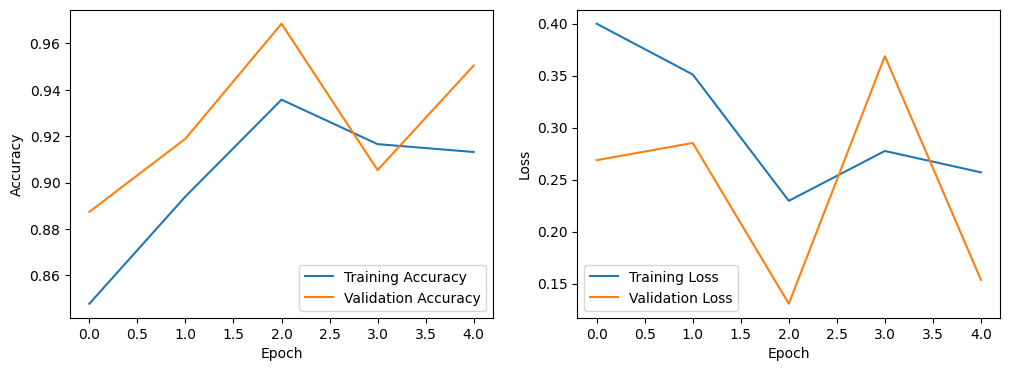

In [10]:


#ploting the history as loss and accuracy data 

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_history(history)

Prediction on model as video is real or fake

In [12]:

def predict_video(video_path):
    
    try:
        vidcap = cv2.VideoCapture(video_path)
        frames = []
        success, image = vidcap.read()
        count = 0
        while success and count < FRAMES_PER_VIDEO:
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            frames.append(image)
            success, image = vidcap.read()
            count += 1
        vidcap.release()
        if len(frames) == FRAMES_PER_VIDEO: 
            video = np.expand_dims(np.array(frames), axis=0) 
            prediction = model.predict(video)[0][0]
            return prediction
        else:
            return None
    except Exception as e:
        print(f"Error processing video: {e}")
        return None


prediction = predict_video(r"C:\Users\ASUS\Videos\Captures\Apply to Y Combinator and 6 more pages - Personal - Microsoft​ Edge 2024-05-24 18-15-07.mp4")  # Replace with video path

if prediction is not None:
    if prediction > 0.5:
        print("Prediction: Fake (Probability:", prediction, ")")
    else:
        print("Prediction: Real (Probability:", prediction, ")")
else:
    print("Error processing video.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Prediction: Real (Probability: 0.0018958406 )
